Demonstrate very simple many to one, one to many and many to many RNN colabs 

## Introduction to RNN
As we already discussed, RNN is used for sequence data handling. And there are several types of RNN architecture.

Types of RNN:

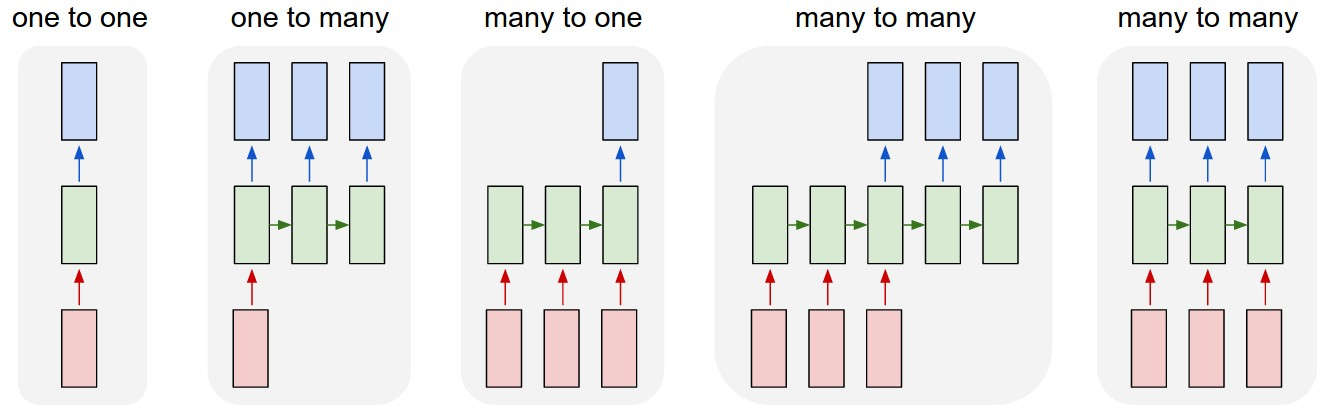


The **one-to-one** type, which is the basic RNN structure. And next one is **one-to-many** type. For example, if the model gets the fixed format like image as an input, it generates the sequence data. You can see the implementation on image caption application. Another type is **many-to-many** type. It gets sequence data as an inputs, and also generates the sequence data as an output. Common application of many-to-many type is machine translation.

##RNN Many to One.     

Many-to-one type, which is our topic in this post, gets an sequence data as an input and generates some informatic data like labels. So we can use it for classification. Suppose that someone defines the sentiment of each sentence, and train the model with many-to-one type. And when the model gets the unseen sentence, then it will predict the intention of sentence, good or bad.

In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print('Tensorflow: {}'.format(tf.__version__))

plt.rcParams['figure.figsize'] = (16, 10)
plt.rc('font', size=15)

Tensorflow: 2.8.0


Word Sentiment Classification

In [27]:
words = ['good', 'bad', 'worse', 'so good']
y = [1, 0, 0, 1]

Based on this, we can generate the token dictionary, which is the mapping table for each characters. But before we prepare this, we need to consider one exceptional case, the variation of each sentence length. To train the network, the format (or shape) of input data must be fixed. So we need to add the concept of padding. Tensorflow has useful API for padding, pad_sequences.

In [28]:
char_set = ['<pad>'] + sorted(list(set(''.join(words))))
idx2char = {idx:char for idx, char in enumerate(char_set)}
char2idx = {char:idx for idx, char in enumerate(char_set)}

In [29]:
char_set

['<pad>', ' ', 'a', 'b', 'd', 'e', 'g', 'o', 'r', 's', 'w']

In [30]:
idx2char

{0: '<pad>',
 1: ' ',
 2: 'a',
 3: 'b',
 4: 'd',
 5: 'e',
 6: 'g',
 7: 'o',
 8: 'r',
 9: 's',
 10: 'w'}

In [31]:
char2idx

{' ': 1,
 '<pad>': 0,
 'a': 2,
 'b': 3,
 'd': 4,
 'e': 5,
 'g': 6,
 'o': 7,
 'r': 8,
 's': 9,
 'w': 10}

In [32]:
X = list(map(lambda word: [char2idx.get(char) for char in word], words))
X_len = list(map(lambda word: len(word), X))

In [33]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Padding the sequence of indices
max_sequence=10

X = pad_sequences(X, maxlen=max_sequence, padding='post', truncating='post')

pad_sequences API with several arguments.    
defined maximum sequence length to 10. So numerical vector has an maximum length of 10. That is, we just consider 10 characters for sequence. And there are some words that has less than 10 characters. In that case, we filled some 0s for padding. 

In [34]:
# Generate data pipeline
train_ds = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(buffer_size=4).batch(batch_size=2)
print(train_ds)

<BatchDataset element_spec=(TensorSpec(shape=(None, 10), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


Many to One model with Simple RNN

In [35]:
input_dim = len(char2idx)
output_dim = len(char2idx)

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

model = Sequential([
    Embedding(input_dim=input_dim, output_dim=output_dim,
              mask_zero=True, input_length=max_sequence,
              trainable=False, embeddings_initializer=tf.keras.initializers.random_normal()),
    SimpleRNN(units=10),
    Dense(2)
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 11)            121       
                                                                 
 simple_rnn (SimpleRNN)      (None, 10)                220       
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 363
Trainable params: 242
Non-trainable params: 121
_________________________________________________________________


In [37]:
def loss_fn(model, X, y):
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_true=y, 
                                                                          y_pred=model(X), 
                                                                          from_logits=True))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [38]:
tr_loss_hist = []

for e in range(30):
    avg_tr_loss = 0
    tr_step = 0
    
    for x_mb, y_mb in train_ds:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x_mb, y_mb)
            
        grads = tape.gradient(tr_loss, sources=model.variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
        avg_tr_loss += tr_loss
        tr_step += 1
    
    avg_tr_loss /= tr_step
    tr_loss_hist.append(avg_tr_loss)
    
    if (e + 1) % 5 == 0:
        print('epoch: {:3}, tr_loss: {:3f}'.format(e + 1, avg_tr_loss))

epoch:   5, tr_loss: 0.202723
epoch:  10, tr_loss: 0.029778
epoch:  15, tr_loss: 0.008483
epoch:  20, tr_loss: 0.004119
epoch:  25, tr_loss: 0.002729
epoch:  30, tr_loss: 0.002086


check performance of simple RNN

In [39]:
y_pred = model.predict(X)
y_pred = np.argmax(y_pred, axis=-1)

In [40]:
print('acc: {:.2%}'.format(np.mean(y_pred == y)))

acc: 100.00%


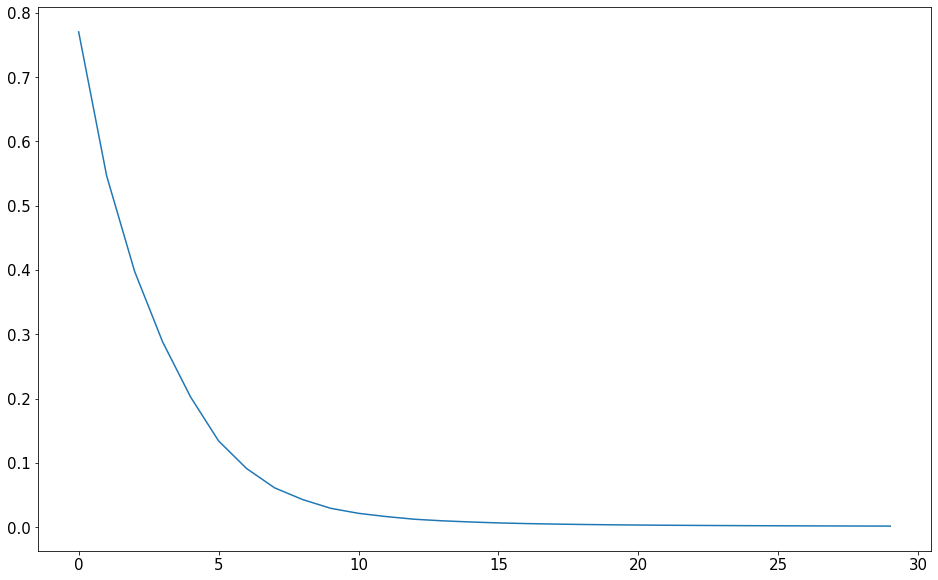

In [41]:
plt.figure()
plt.plot(tr_loss_hist)
plt.show()

##RNN Many to Many

example for Many to Many is Part of Speech Tagging.    

Prepare Datset.   
Implement the simple many-to-many model for POS tagging.  

In [42]:
sentences = [['I', 'feel', 'hungry'],
             ['tensorflow', 'is', 'very', 'difficult'],
             ['tensorflow', 'is', 'a', 'framework', 'for', 'deep', 'learning'],
             ['tensorflow', 'is', 'very', 'fast', 'changing']]

pos = [['pronoun', 'verb', 'adjective'], 
       ['noun', 'verb', 'adverb', 'adjective'],
       ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
       ['noun', 'verb', 'adverb', 'adjective', 'verb']]

Build token dictionary. Build POS dictionary

In [43]:
word_list =['<pad>'] + sorted(set(sum(sentences, []))) 
word2idx = {word:idx for idx, word in enumerate(word_list)}
idx2word = {idx:word for idx, word in enumerate(word_list)}

print(word_list)
print(word2idx)
print(idx2word)

['<pad>', 'I', 'a', 'changing', 'deep', 'difficult', 'fast', 'feel', 'for', 'framework', 'hungry', 'is', 'learning', 'tensorflow', 'very']
{'<pad>': 0, 'I': 1, 'a': 2, 'changing': 3, 'deep': 4, 'difficult': 5, 'fast': 6, 'feel': 7, 'for': 8, 'framework': 9, 'hungry': 10, 'is': 11, 'learning': 12, 'tensorflow': 13, 'very': 14}
{0: '<pad>', 1: 'I', 2: 'a', 3: 'changing', 4: 'deep', 5: 'difficult', 6: 'fast', 7: 'feel', 8: 'for', 9: 'framework', 10: 'hungry', 11: 'is', 12: 'learning', 13: 'tensorflow', 14: 'very'}


In [44]:
pos_list = ['<pad>'] + sorted(set(sum(pos, [])))
pos2idx = {pos:idx for idx, pos in enumerate(pos_list)}
idx2pos = {idx:pos for idx, pos in enumerate(pos_list)}

print(pos_list)
print(pos2idx)
print(idx2pos)

['<pad>', 'adjective', 'adverb', 'determiner', 'noun', 'preposition', 'pronoun', 'verb']
{'<pad>': 0, 'adjective': 1, 'adverb': 2, 'determiner': 3, 'noun': 4, 'preposition': 5, 'pronoun': 6, 'verb': 7}
{0: '<pad>', 1: 'adjective', 2: 'adverb', 3: 'determiner', 4: 'noun', 5: 'preposition', 6: 'pronoun', 7: 'verb'}


Build dictionary for dataset And the convert sentence to numeric vector

In [45]:
X = list(map(lambda sentence: [word2idx.get(token) for token in sentence], sentences))
y = list(map(lambda sentence: [pos2idx.get(token) for token in sentence], pos))

print(X)
print(y)

[[1, 7, 10], [13, 11, 14, 5], [13, 11, 2, 9, 8, 4, 12], [13, 11, 14, 6, 3]]
[[6, 7, 1], [4, 7, 2, 1], [4, 7, 3, 4, 5, 1, 4], [4, 7, 2, 1, 7]]


In [46]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = pad_sequences(X, maxlen=10, padding='post')
X_mask = (X != 0).astype(np.float32)
X_len = np.array(list((map(lambda sentence: len(sentence), sentences))), dtype=np.float32)

print(X)
print(X_mask)
print(X_len)

[[ 1  7 10  0  0  0  0  0  0  0]
 [13 11 14  5  0  0  0  0  0  0]
 [13 11  2  9  8  4 12  0  0  0]
 [13 11 14  6  3  0  0  0  0  0]]
[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]]
[3. 4. 7. 5.]


Length of each sentence is different. So, use pad_sequence to fix the length

In [47]:
y = pad_sequences(y, maxlen=10, padding='post')

print(y)

[[6 7 1 0 0 0 0 0 0 0]
 [4 7 2 1 0 0 0 0 0 0]
 [4 7 3 4 5 1 4 0 0 0]
 [4 7 2 1 7 0 0 0 0 0]]


In [48]:
train_ds = tf.data.Dataset.from_tensor_slices((X, y, X_len)).shuffle(buffer_size=4).batch(batch_size=2)

print(train_ds)

<BatchDataset element_spec=(TensorSpec(shape=(None, 10), dtype=tf.int32, name=None), TensorSpec(shape=(None, 10), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


Model implementation

In [49]:
num_classes = len(pos2idx)
input_dim = len(word2idx)
output_dim = len(word2idx)

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, TimeDistributed, Dense, SimpleRNN

model = Sequential([
    Embedding(input_dim=input_dim, output_dim=output_dim,
              mask_zero=True, trainable=False, input_length=10,
              embeddings_initializer=tf.keras.initializers.random_normal()),
    SimpleRNN(units=10, return_sequences=True),
    TimeDistributed(Dense(units=num_classes))
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 15)            225       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10, 10)            260       
                                                                 
 time_distributed (TimeDistr  (None, 10, 8)            88        
 ibuted)                                                         
                                                                 
Total params: 573
Trainable params: 348
Non-trainable params: 225
_________________________________________________________________


In [51]:
def loss_fn(model, x, y, x_len, max_sequence):
    masking = tf.sequence_mask(x_len, maxlen=max_sequence, dtype=tf.float32)
    sequence_loss = tf.keras.losses.sparse_categorical_crossentropy(
        y_true=y, y_pred=model(x), from_logits=True
    ) * masking
    sequence_loss = tf.reduce_mean(tf.reduce_sum(sequence_loss, axis=1) / x_len)
    return sequence_loss

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

In [52]:
tr_loss_hist = []

for e in range(30):
    avg_tr_loss = 0
    tr_step = 0
    
    for x_mb, y_mb, x_mb_len in train_ds:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x_mb, y_mb, x_mb_len, max_sequence=10)
        grads = tape.gradient(tr_loss, model.trainable_variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.trainable_variables))
        avg_tr_loss += tr_loss
        tr_step += 1
    avg_tr_loss /= tr_step
    tr_loss_hist.append(avg_tr_loss)
    
    if (e + 1) % 5 == 0:
        print('Epoch: {:3}, tr_loss: {:.3f}'.format(e+1, avg_tr_loss))

Epoch:   5, tr_loss: 0.710
Epoch:  10, tr_loss: 0.275
Epoch:  15, tr_loss: 0.213
Epoch:  20, tr_loss: 0.189
Epoch:  25, tr_loss: 0.183
Epoch:  30, tr_loss: 0.168


In [53]:
y_pred = model.predict(X)
y_pred = np.argmax(y_pred, axis=-1) * X_mask

y_pred

array([[6., 7., 1., 0., 0., 0., 0., 0., 0., 0.],
       [4., 7., 2., 1., 0., 0., 0., 0., 0., 0.],
       [4., 7., 2., 1., 5., 1., 4., 0., 0., 0.],
       [4., 7., 2., 1., 7., 0., 0., 0., 0., 0.]])

convert numeric vector to POS with idx2pos dictionary to visualize model

In [54]:
from pprint import pprint

y_pred_pos = list(map(lambda row: [idx2pos.get(elm) for elm in row], y_pred.astype(np.int32).tolist()))

pprint(y_pred_pos)

pprint(pos)

[['pronoun',
  'verb',
  'adjective',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>'],
 ['noun',
  'verb',
  'adverb',
  'adjective',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>'],
 ['noun',
  'verb',
  'adverb',
  'adjective',
  'preposition',
  'adjective',
  'noun',
  '<pad>',
  '<pad>',
  '<pad>'],
 ['noun',
  'verb',
  'adverb',
  'adjective',
  'verb',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>']]
[['pronoun', 'verb', 'adjective'],
 ['noun', 'verb', 'adverb', 'adjective'],
 ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
 ['noun', 'verb', 'adverb', 'adjective', 'verb']]


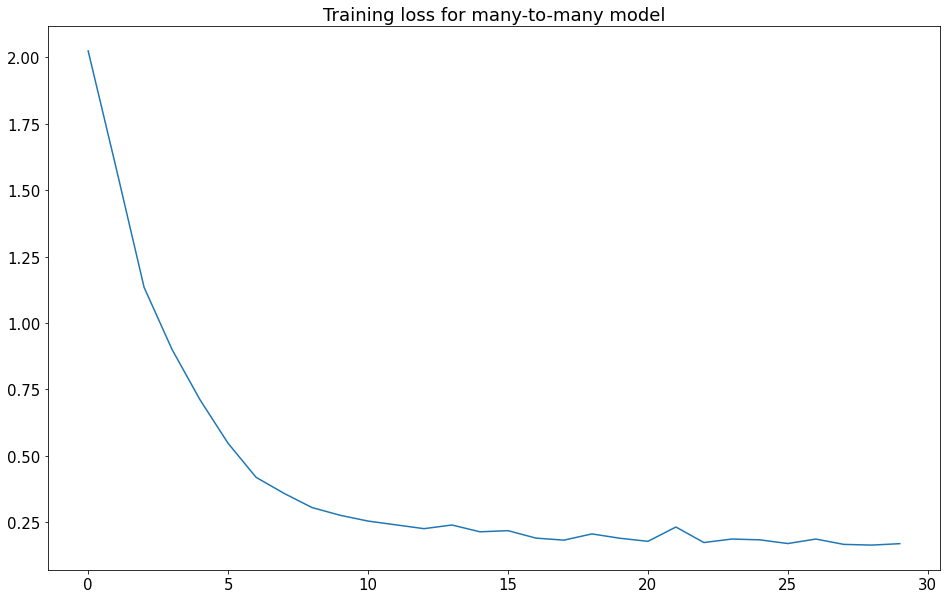

In [55]:
plt.figure()
plt.plot(tr_loss_hist)
plt.title('Training loss for many-to-many model')
plt.show()

##RNN Many to One

For many to one RNN Word sentiment classification

In [56]:
words = ['good', 'bad', 'worse', 'so good'] #dummy data for simple classification
y = [1, 0, 0, 1]

Based on the data generate token dictionary, which is mapping table for each character

In [57]:
char_set = ['<pad>'] + sorted(list(set(''.join(words))))
idx2char = {idx:char for idx, char in enumerate(char_set)}
char2idx = {char:idx for idx, char in enumerate(char_set)}

In [58]:
char_set

['<pad>', ' ', 'a', 'b', 'd', 'e', 'g', 'o', 'r', 's', 'w']

In [59]:
idx2char

{0: '<pad>',
 1: ' ',
 2: 'a',
 3: 'b',
 4: 'd',
 5: 'e',
 6: 'g',
 7: 'o',
 8: 'r',
 9: 's',
 10: 'w'}

In [60]:
char2idx

{' ': 1,
 '<pad>': 0,
 'a': 2,
 'b': 3,
 'd': 4,
 'e': 5,
 'g': 6,
 'o': 7,
 'r': 8,
 's': 9,
 'w': 10}

In [61]:
X = list(map(lambda word: [char2idx.get(char) for char in word], words))
X_len = list(map(lambda word: len(word), X))

In [62]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Padding the sequence of indices
max_sequence=10

X = pad_sequences(X, maxlen=max_sequence, padding='post', truncating='post')

use pad_sequences API with several arguments. 

In [63]:
# Generate data pipeline
train_ds = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(buffer_size=4).batch(batch_size=2)
print(train_ds)

<BatchDataset element_spec=(TensorSpec(shape=(None, 10), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


Build many to one model with simple RNN

In [64]:
input_dim = len(char2idx)
output_dim = len(char2idx)

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

model = Sequential([
    Embedding(input_dim=input_dim, output_dim=output_dim,
              mask_zero=True, input_length=max_sequence,
              trainable=False, embeddings_initializer=tf.keras.initializers.random_normal()),
    SimpleRNN(units=10),
    Dense(2)
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 10, 11)            121       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 10)                220       
                                                                 
 dense_4 (Dense)             (None, 2)                 22        
                                                                 
Total params: 363
Trainable params: 242
Non-trainable params: 121
_________________________________________________________________


In [66]:
def loss_fn(model, X, y):
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_true=y, 
                                                                          y_pred=model(X), 
                                                                          from_logits=True))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [67]:
tr_loss_hist = []

for e in range(30):
    avg_tr_loss = 0
    tr_step = 0
    
    for x_mb, y_mb in train_ds:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x_mb, y_mb)
            
        grads = tape.gradient(tr_loss, sources=model.variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
        avg_tr_loss += tr_loss
        tr_step += 1
    
    avg_tr_loss /= tr_step
    tr_loss_hist.append(avg_tr_loss)
    
    if (e + 1) % 5 == 0:
        print('epoch: {:3}, tr_loss: {:3f}'.format(e + 1, avg_tr_loss))

epoch:   5, tr_loss: 0.242700
epoch:  10, tr_loss: 0.016581
epoch:  15, tr_loss: 0.002444
epoch:  20, tr_loss: 0.001063
epoch:  25, tr_loss: 0.000728
epoch:  30, tr_loss: 0.000600


In [68]:
y_pred = model.predict(X)
y_pred = np.argmax(y_pred, axis=-1)

In [69]:
print('acc: {:.2%}'.format(np.mean(y_pred == y)))

acc: 100.00%


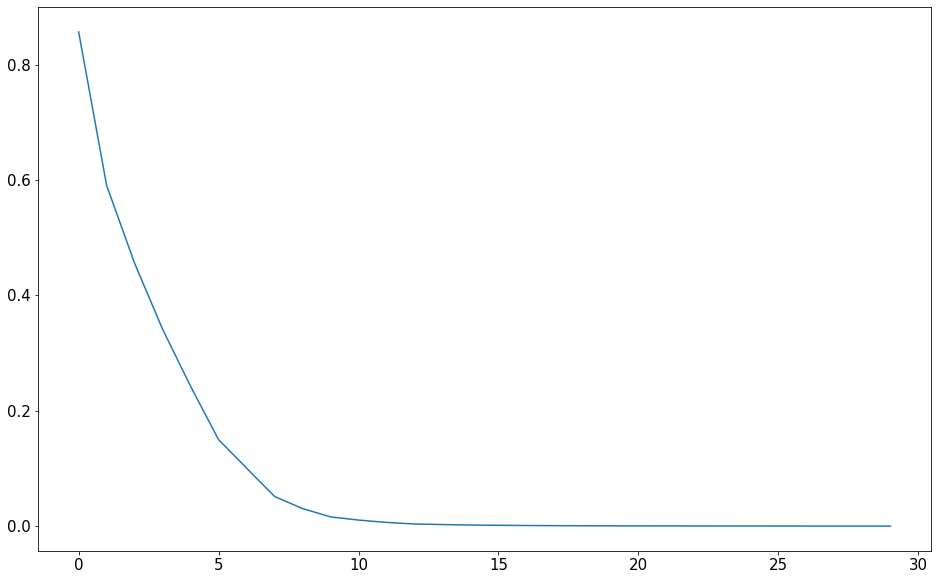

In [70]:
plt.figure()
plt.plot(tr_loss_hist)
plt.show()

##RNN One to Many

In [71]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [72]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional

import pandas as pd
import numpy as np
import re


Creating the data

In [73]:
X = list()
Y = list()
X = [x+3 for x in range(-2, 43, 3)]

for i in X:
    output_vector = list()
    output_vector.append(i+1)
    output_vector.append(i+2)
    Y.append(output_vector)

print(X)
print(Y)

[1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43]
[[2, 3], [5, 6], [8, 9], [11, 12], [14, 15], [17, 18], [20, 21], [23, 24], [26, 27], [29, 30], [32, 33], [35, 36], [38, 39], [41, 42], [44, 45]]


In [74]:
X = np.array(X).reshape(15, 1, 1)
Y = np.array(Y)

In [75]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(1, 1)))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse')
model.fit(X, Y, epochs=50, validation_split=0.2, batch_size=3)

Epoch 1/50
4/4 [==============================] - 1s 80ms/step - loss: 466.4401 - val_loss: 1699.8439
Epoch 2/50
4/4 [==============================] - 0s 10ms/step - loss: 461.2080 - val_loss: 1684.1727
Epoch 3/50
4/4 [==============================] - 0s 11ms/step - loss: 456.3206 - val_loss: 1667.7494
Epoch 4/50
4/4 [==============================] - 0s 10ms/step - loss: 450.9183 - val_loss: 1651.2256
Epoch 5/50
4/4 [==============================] - 0s 10ms/step - loss: 446.1797 - val_loss: 1633.3209
Epoch 6/50
4/4 [==============================] - 0s 12ms/step - loss: 440.6726 - val_loss: 1614.5127
Epoch 7/50
4/4 [==============================] - 0s 14ms/step - loss: 434.3449 - val_loss: 1595.2301
Epoch 8/50
4/4 [==============================] - 0s 11ms/step - loss: 429.5063 - val_loss: 1573.3470
Epoch 9/50
4/4 [==============================] - 0s 11ms/step - loss: 422.3970 - val_loss: 1550.3218
Epoch 10/50
4/4 [==============================] - 0s 11ms/step - loss: 416.3768 -

In [76]:
test_input = array([10])
test_input = test_input.reshape((1, 1, 1))
test_output = model.predict(test_input, verbose=0)
print(test_output)

[[8.135339 8.834038]]
